### Situação:

Usando os dados das licitações do ano de 2021, no Rio Grande do Sul, fazer uma análise dos principais itens licitados e das áreas que receberam maior investimento por meio de licitações

Link: http://dados.tce.rs.gov.br/dataset?groups=licitacoes&q=consolidado

Referências:

https://github.com/PatrickLdA/licitacoes-RS/blob/main/notebook.ipynb

https://medium.com/somos-tera/como-modelar-t%C3%B3picos-atrav%C3%A9s-de-latent-dirichlet-allocation-lda-atrav%C3%A9s-da-biblioteca-gensim-1fa17357ad4b

### Imports

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
#
import spacy 
import nltk

In [4]:
files = os.listdir('/2021')

In [5]:
files

['memcomissao.csv',
 'evento_lic.csv',
 'documento_lic.csv',
 'licitante.csv',
 'licitacao.csv',
 'item.csv',
 'pessoas.csv',
 'dotacao_lic.csv',
 'comissao.csv',
 'membrocons.csv',
 'proposta.csv',
 'item_prop.csv',
 'lote_prop.csv',
 'lote.csv']

In [7]:
licitacao = pd.read_csv('/NLP/2021/' + files[4])
item = pd.read_csv('/NLP/2021/' + files[5])

/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (8,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Pré-processamento Dados

In [8]:
cols = ['CD_ORGAO', 'NM_ORGAO', 'NR_LICITACAO', 'CD_TIPO_MODALIDADE','DS_OBJETO', 'VL_LICITACAO', 'BL_COVID19']
licitacao_21 = licitacao[cols]

In [9]:
licitacao_21 = licitacao_21.dropna()

In [10]:
licitacao_21.head(3)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,DS_OBJETO,VL_LICITACAO,BL_COVID19
0,53100,PM DE NOVA PALMA,1.0,TMP,CONTRATAÇÃO GLOBAL DE EMPRESA PARA CONSTRUÇÃO ...,259765.0,N
1,86800,PM DE BOA VISTA DO SUL,2.0,PRP,Contratação de empresa para prestação de servi...,390625.0,N
2,45003,SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL,46.0,PRP,Aquisição de 80.000 (oitenta mil) quilogramas ...,833800.0,N


In [11]:
item_licitacao = item.iloc[:, 0:12]
item_licitacao['BL_COVID19'] = item['BL_COVID19'] 

In [12]:
item_licitacao.isna().sum()

CD_ORGAO                    0
NR_LICITACAO                0
ANO_LICITACAO               0
CD_TIPO_MODALIDADE          0
NR_LOTE                     0
NR_ITEM                     0
NR_ITEM_ORIGINAL            0
DS_ITEM                     1
QT_ITENS                    0
SG_UNIDADE_MEDIDA           0
VL_UNITARIO_ESTIMADO    39446
VL_TOTAL_ESTIMADO       39446
BL_COVID19                  0
dtype: int64

In [13]:
item_licitacao = item_licitacao.dropna()

In [14]:
len(licitacao_21), len(item_licitacao)

(87469, 932800)

In [15]:
licitacao_21['covid'] = np.where((licitacao_21['BL_COVID19'] == 'S'), ' covid19', '')
licitacao_21['DS_OBJETO'] = licitacao_21['DS_OBJETO'] + licitacao_21['covid']

In [16]:
licitacao_21 = licitacao_21.drop(['BL_COVID19', 'covid'], axis = 1)

In [18]:
item_licitacao['covid'] = np.where((item_licitacao['BL_COVID19'] == 'S'), ' covid19', '')
item_licitacao['DS_ITEM'] = item_licitacao['DS_ITEM'] + item_licitacao['covid']

In [19]:
item_licitacao = item_licitacao.drop(['BL_COVID19', 'covid'], axis = 1)

In [20]:
item_licitacao['ANO_LICITACAO'].unique()
item_licitacao.drop(['ANO_LICITACAO'], axis = 1).head(3)

,CD_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO
0,44500,274.0,CPC,1,1,1,Credenciamento de academias de ginástica e mus...,1,UN,50.00,50.00
1,56900,25.0,TMP,1,1,1.1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,6,M2,272.49,1634.94
2,56900,25.0,TMP,1,2,1.2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,71,M2,128.69,9136.99


### Pré-processamento Texto

In [11]:
# Libs adicionais de NLP
import spacy 
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

In [39]:
nlp=spacy.load("pt_core_news_sm")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ionasantana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stopwords = nltk.corpus.stopwords.words('portuguese')

filter_out = stopwords + ['kg', 'm', 'cm', 'mm', 'mg', 'ml', 'm²', '-', '+', '=', 'mcg', 'nº', 'g', 'ª', 'º']

Para o pré-processamento do texto foi usado linguagem regular, a tabela abaixo contém algumas informações utéis para entender a função de pre_processing

<table ><tr><th>Character</th><th>Description</th><th>Example Pattern Code</th><th >Exammple Match</th></tr>

<tr ><td><span >\d</span></td><td>A digit</td><td>file_\d\d</td><td>file_25</td></tr>

<tr ><td><span >\w</span></td><td>Alphanumeric</td><td>\w-\w\w\w</td><td>A-b_1</td></tr>



<tr ><td><span >\s</span></td><td>White space</td><td>a\sb\sc</td><td>a b c</td></tr>



<tr ><td><span >\D</span></td><td>A non digit</td><td>\D\D\D</td><td>ABC</td></tr>

<tr ><td><span >\W</span></td><td>Non-alphanumeric</td><td>\W\W\W\W\W</td><td>*-+=)</td></tr>

<tr ><td><span >\S</span></td><td>Non-whitespace</td><td>\S\S\S\S</td><td>Yoyo</td></tr></table>
<table ><tr><th>Character</th><th>Description</th><th>Example Pattern Code</th><th >Exammple Match</th></tr>
</br>
<tr ><td><span >+</span></td><td>Occurs one or more times</td><td>	Version \w-\w+</td><td>Version A-b1_1</td></tr>

<tr ><td><span >{3}</span></td><td>Occurs exactly 3 times</td><td>\D{3}</td><td>abc</td></tr>



<tr ><td><span >{2,4}</span></td><td>Occurs 2 to 4 times</td><td>\d{2,4}</td><td>123</td></tr>



<tr ><td><span >{3,}</span></td><td>Occurs 3 or more</td><td>\w{3,}</td><td>anycharacters</td></tr>

<tr ><td><span >\*</span></td><td>Occurs zero or more times</td><td>A\*B\*C*</td><td>AAACC</td></tr>

<tr ><td><span >?</span></td><td>Once or none</td><td>plurals?</td><td>plural</td></tr></table>

Fonte: adaptado do curso - NLP - Natural Language Processing with Python - Udemy

Instrutor: Jose Portilla


In [72]:
def pre_processing(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^\w\s]", "", sentence)
    sentence = re.sub(r"[0-9]+", "", sentence)
    sentence = re.sub(r"/+", "", sentence)
    sentence = re.sub(r" {2,}", " ", sentence)

    #Tokenização
    doc = nlp(sentence)

    tokens=[token.text for token in doc]
    tokens=[token for token in tokens if token not in filter_out]

    return tokens


In [75]:
print(pre_processing('testando 1 2 3 aa'))

['testando', 'aa']


In [76]:
item_licitacao['DS_ITEM_TOKEN'] = item_licitacao['DS_ITEM'].apply(lambda sentece: pre_processing(sentece))


In [77]:
item_licitacao.to_csv('item_licitacao_token.csv')

In [78]:
licitacao_21['DS_OBJETO_TOKEN'] = licitacao_21['DS_OBJETO'].apply(lambda sentece: pre_processing(sentece))


In [79]:
licitacao_21.to_csv('licitacao_21_token.csv')

### Construção dos modelos

Counter Vectorizarion -> contar a ocorrência de cada palavra para mapear o texto para um número

CounterVectorizer

TfidfVectorizer -> cria a mais uma matriz de termos de documento a partir de nossas mensagens.
No entanto, em vez de preencher o DTM com contagens de token, ele calcula o valor da frequência do documento inverso da frequência do termo para cada palavra (TF-IDF).
Um fator de frequência de documento inverso é incorporado, o que diminui o peso dos termos que ocorrem com muita frequência no conjunto de documentos e aumenta o peso dos termos que ocorrem raramente.


In [80]:
licitacao_21.head(3)

,CD_ORGAO,NM_ORGAO,NR_LICITACAO,CD_TIPO_MODALIDADE,DS_OBJETO,VL_LICITACAO,DS_OBJETO_TOKEN
0,53100,PM DE NOVA PALMA,1.0,TMP,CONTRATAÇÃO GLOBAL DE EMPRESA PARA CONSTRUÇÃO ...,259765.0,"[contratação, global, empresa, construção, par..."
1,86800,PM DE BOA VISTA DO SUL,2.0,PRP,Contratação de empresa para prestação de servi...,390625.0,"[contratação, empresa, prestação, serviços, tr..."
2,45003,SERVIÇO AUTÔN. MUN. DE ÁGUA E ESGOTO - CX.SUL,46.0,PRP,Aquisição de 80.000 (oitenta mil) quilogramas ...,833800.0,"[aquisição, oitenta, mil, quilogramas, ortopol..."


In [81]:
item_licitacao.head(3)

,CD_ORGAO,NR_LICITACAO,ANO_LICITACAO,CD_TIPO_MODALIDADE,NR_LOTE,NR_ITEM,NR_ITEM_ORIGINAL,DS_ITEM,QT_ITENS,SG_UNIDADE_MEDIDA,VL_UNITARIO_ESTIMADO,VL_TOTAL_ESTIMADO,DS_ITEM_TOKEN
0,44500,274.0,2021,CPC,1,1,1,Credenciamento de academias de ginástica e mus...,1,UN,50.00,50.00,"[credenciamento, academias, ginástica, muscula..."
1,56900,25.0,2021,TMP,1,1,1.1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,6,M2,272.49,1634.94,"[placa, obra, construcao, civil, chapa, galvan..."
2,56900,25.0,2021,TMP,1,2,1.2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,71,M2,128.69,9136.99,"[tapume, compensado, madeira, af, _]"


In [6]:
licitacao_21 = pd.read_csv('licitacao_21_token.csv')
item_licitacao = pd.read_csv('item_licitacao_token.csv')

/Users/ionasantana/opt/anaconda3/envs/nlp_course/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.ldamulticore import LdaMulticore
from tqdm import tqdm

In [12]:
item_licitacao.columns

Index(['Unnamed: 0', 'CD_ORGAO', 'NR_LICITACAO', 'ANO_LICITACAO',
       'CD_TIPO_MODALIDADE', 'NR_LOTE', 'NR_ITEM', 'NR_ITEM_ORIGINAL',
       'DS_ITEM', 'QT_ITENS', 'SG_UNIDADE_MEDIDA', 'VL_UNITARIO_ESTIMADO',
       'VL_TOTAL_ESTIMADO', 'DS_ITEM_TOKEN'],
      dtype='object')

In [13]:
lic= [d.split() for d in item_licitacao['DS_ITEM_TOKEN']]


In [15]:
id2word = corpora.Dictionary(lic)

In [16]:
texts = item_licitacao['DS_ITEM_TOKEN']

In [17]:
corpus = [id2word.doc2bow(text.split()) for text in texts]

# Visualização
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [18]:
# Corpus num formado simplificado (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[("'academias',", 1),
  ("'cada',", 1),
  ("'canoas',", 1),
  ("'credenciado',", 1),
  ("'desembolsado',", 1),
  ("'escolhido',", 1),
  ("'estabelecimento',", 2),
  ("'exercícios',", 1),
  ("'físicos',", 1),
  ("'ginástica',", 1),
  ("'matriculado',", 1),
  ("'ministrem',", 1),
  ("'município',", 3),
  ("'musculação',", 1),
  ("'outro',", 1),
  ("'r',", 1),
  ("'servidor',", 1),
  ("'servidor']", 1),
  ("'valor',", 1),
  ("'âmbito',", 1),
  ("['credenciamento',", 1)]]

LDA

In [19]:
from sklearn.decomposition import LatentDirichletAllocation

#gráficos 
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

In [20]:
filter_out = filter_out + ['cor', 'cores', 'un', 'branco', 'unidades', 
'litros', 'af', 'mgml', 'nbr', 'dn', 'eou', 'referência', 'conforme',
'demais', 'deverá', 'tipo', 'r', 'gb', 'km']


Comparar TfidfVectorizer e CountVectorizer

In [21]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words=filter_out)

In [22]:
tv = TfidfVectorizer(stop_words=filter_out) #acrescentar outras informações

NameError: name 'TfidfVectorizer' is not defined

In [23]:
dtm = cv.fit_transform(item_licitacao['DS_ITEM_TOKEN'])

Função de coerência

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lic, start=2, limit=30, step=2)

100%|██████████| 14/14 [17:08<00:00, 73.48s/it]


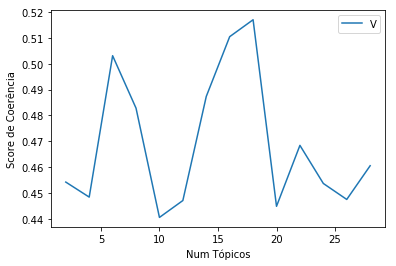

In [34]:
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [35]:
for m, c in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(c, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.4542
A quantidade de tópicos = 4  tem um valor de coerência de  0.4484
A quantidade de tópicos = 6  tem um valor de coerência de  0.5031
A quantidade de tópicos = 8  tem um valor de coerência de  0.4828
A quantidade de tópicos = 10  tem um valor de coerência de  0.4405
A quantidade de tópicos = 12  tem um valor de coerência de  0.447
A quantidade de tópicos = 14  tem um valor de coerência de  0.4873
A quantidade de tópicos = 16  tem um valor de coerência de  0.5104
A quantidade de tópicos = 18  tem um valor de coerência de  0.517
A quantidade de tópicos = 20  tem um valor de coerência de  0.4448
A quantidade de tópicos = 22  tem um valor de coerência de  0.4684
A quantidade de tópicos = 24  tem um valor de coerência de  0.4536
A quantidade de tópicos = 26  tem um valor de coerência de  0.4475
A quantidade de tópicos = 28  tem um valor de coerência de  0.4605


16 ou 18 tópicos

In [28]:
LDA = LatentDirichletAllocation(n_components=10,random_state=42)
LDA.fit(dtm)
LDA.components_
single_topic = LDA.components_[0]
# Returns the indices that would sort this array.
single_topic.argsort()
top_word_indices = single_topic.argsort()[-10:]
for index in top_word_indices:
    print(cv.get_feature_names()[index])


In [ ]:
for index,topic in enumerate(LDA.components_):
    print(f'Top 10 tópicos dos itens#{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 tópicos dos itens#0
['tamanho', 'azul', 'pacote', 'branca', 'rolo', 'tinta', 'fita', 'folhas', 'pvc', 'papel']


Top 10 tópicos dos itens#1
['portas', 'ar', 'led', 'altura', 'porta', 'garantia', 'mínima', 'pintura', 'capacidade', 'mínimo']


Top 10 tópicos dos itens#2
['caixa', 'medindo', 'borracha', 'madeira', 'algodão', 'altura', 'luva', 'largura', 'tecido', 'tamanho']


Top 10 tópicos dos itens#3
['diâmetro', 'pvc', 'instalação', 'inox', 'concreto', 'agulha', 'fio', 'tubo', 'cabo', 'aço']


Top 10 tópicos dos itens#4
['mão', 'transporte', 'município', 'municipal', 'obra', 'prestação', 'empresa', 'contratação', 'serviço', 'serviços']


Top 10 tópicos dos itens#5
['caneta', 'sonda', 'documentação', 'cotação', 'reforma', 'construção', 'caixa', 'especificações', 'covid', 'termo']


Top 10 tópicos dos itens#6
['contendo', 'mínimo', 'fabricação', 'mínima', 'entrega', 'meses', 'produto', 'data', 'validade', 'embalagem']


Top 10 tópicos dos itens#7
['comprimido', 'novo', 'lonas', 'v

porque o multicore nao esse de cima?

In [ ]:
lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=5, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)

Após o processamento, se encontrou palavras como cor, un, af, tipo - então elas foram adicionadas no filtro e foi se processado novamente

In [35]:
#LDA Antes
# dtm
# dtm.shape
# topic_results = LDA.transform(dtm)
# topic_results.shape
# item_licitacao['Topic'] = topic_results.argmax(axis=1)
# item_licitacao[['DS_ITEM','Topic']].head(10)
# item_licitacao[['DS_ITEM_TOKEN','Topic']].head(10)

<932800x84243 sparse matrix of type '<class 'numpy.longlong'>'
	with 7499172 stored elements in Compressed Sparse Row format>

In [42]:
item_licitacao.to_csv('lda.csv') #lda1, LatentDirichletAllocation

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
display_data = pyLDAvis.sklearn.prepare(LDA, cv.fit_transform(item_licitacao['DS_ITEM_TOKEN']), cv) #LDA -> lda_model

In [ ]:
pyLDAvis.display(display_data)  

In [ ]:
display_data_lda2 = pyLDAvis.sklearn.prepare(lda_model, cv.fit_transform(item_licitacao['DS_ITEM_TOKEN']), cv) #LDA -> lda_model

In [ ]:
pyLDAvis.display(display_data_lda2)  

In [ ]:
item_licitacao['Topic_lda_multicore'] = 

In [ ]:
item_licitacao.to_csv('lda_multicore.csv')

Qual a diferença entre LDA e NMF?


Desvendando o latent Dirichlet Allocation - https://web.icmc.usp.br

O objetivo é esclarecer essa relação em termos de formulação matemática, demonstrando que o NMF com divergência KL aproxima a solução obtida pelo algoritmo de inferência variacional do LDA.

As correspondências entre NMF com divergência KL e o algoritmo de inferência variacio- nal para o LDA seguem do fato de que ambos tentam minimizar a divergência entre as estatísticas que relacionam a frequência de palavras, documentos por tópicos e tópicos por palavras. 

NMF

wordclouds

In [43]:
from sklearn.decomposition import NMF

In [44]:
nmf_model = NMF(n_components=20,random_state=42)

In [45]:
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

In [105]:
len(nmf_model.components_)

20

In [102]:
for index,topic in enumerate(nmf_model.components_):
    print(f"Top 10 tópicos dos itens#{index}")
    print([cv.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 tópicos dos itens#0
['partir', 'ingredientes', 'prazo', 'contar', 'mínima', 'fabricação', 'entrega', 'meses', 'validade', 'data']


Top 10 tópicos dos itens#1
['ré', 'cabine', 'índice', 'caçamba', 'operacional', 'potência', 'comprimento', 'peso', 'prazo', 'mínimo']


Top 10 tópicos dos itens#2
['tampo', 'mesa', 'acabamento', 'inox', 'pintura', 'chapa', 'tubo', 'espessura', 'estrutura', 'aço']


Top 10 tópicos dos itens#3
['instalação', 'novaampliação', 'memorial', 'obra', 'documentação', 'cotação', 'reforma', 'construção', 'especificações', 'termo']


Top 10 tópicos dos itens#4
['maturação', 'coloração', 'sujidades', 'primeira', 'boa', 'casca', 'grau', 'médio', 'qualidade', 'tamanho']


Top 10 tópicos dos itens#5
['obra', 'saúde', 'horas', 'municipal', 'município', 'empresa', 'prestação', 'serviço', 'contratação', 'serviços']


Top 10 tópicos dos itens#6
['litro', 'gramas', 'validade', 'leite', 'transparente', 'pó', 'registro', 'resistente', 'plástica', 'embalagem']


Top 10 tóp

In [47]:
topic_results_nfm = nmf_model.transform(dtm)

In [48]:
topic_results_nfm.argmax(axis=1)

item_licitacao['Topic_nfm'] = topic_results.argmax(axis=1)

In [49]:
item_licitacao[['DS_ITEM','Topic_nfm']].head(10)

,DS_ITEM,Topic_nfm
0,Credenciamento de academias de ginástica e mus...,4
1,PLACA DE OBRA (PARA CONSTRUCAO CIVIL) EM CHAPA...,2
2,TAPUME COM COMPENSADO DE MADEIRA. AF_05/2018,2
3,PODA EM ALTURA DE ÁRVORE COM DIÂMETRO DE TRONC...,3
4,"LOCACAO DE CONTAINER 2,30 X 6,00 M, ALT. 2,5...",9
5,"LOCACAO CONVENCIONAL DE OBRA, UTILIZANDO GABAR...",4
6,RECOMPOSIÇÃO PARCIAL DE ARAME FARPADO Nº 14 CL...,3
7,"LIMPEZA MECANIZADA DE CAMADA VEGETAL, VEGETAÇÃ...",7
8,ARQUITETO PLENO,4
9,ENCARREGADO GERAL DE OBRAS,4


In [50]:
item_licitacao[['DS_ITEM_TOKEN','Topic_nfm']].head(10)

,DS_ITEM_TOKEN,Topic_nfm
0,"['credenciamento', 'academias', 'ginástica', '...",4
1,"['placa', 'obra', 'construcao', 'civil', 'chap...",2
2,"['tapume', 'compensado', 'madeira', 'af', '_']",2
3,"['poda', 'altura', 'árvore', 'diâmetro', 'tron...",3
4,"['locacao', 'container', 'x', 'alt', 'escritor...",9
5,"['locacao', 'convencional', 'obra', 'utilizand...",4
6,"['recomposição', 'parcial', 'arame', 'farpado'...",3
7,"['limpeza', 'mecanizada', 'camada', 'vegetal',...",7
8,"['arquiteto', 'pleno']",4
9,"['encarregado', 'geral', 'obras']",4


In [51]:
item_licitacao.to_csv('nfm.csv')

K-means

### Análise dos dados

Comparar os tópicos entre os dois

### Conclusão

Counter Vectorizarion -> contar a ocorrência de cada palavra para mapear o texto para um número

CounterVectorizer

TfidfVectorizer -> cria a mais uma matriz de termos de documento a partir de nossas mensagens.
No entanto, em vez de preencher o DTM com contagens de token, ele calcula o valor da frequência do documento inverso da frequência do termo para cada palavra (TF-IDF).
Um fator de frequência de documento inverso é incorporado, o que diminui o peso dos termos que ocorrem com muita frequência no conjunto de documentos e aumenta o peso dos termos que ocorrem raramente.


Quais foram as áreas com maiores investimentos?

E quais foram os principais itens licitados nelas?